# Imports


In [1]:

"""
Cluster Visualization Script
----------------------------
This script analyzes cluster data, assigns distinct colors to clusters,
and visualizes the color assignments.
"""

import colorsys  # Add this import for HSV to RGB conversion
import json
import os
from math import pi, sin
from typing import Any, Dict, List, Optional, Tuple

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from matplotlib.colors import to_hex


# --- Configuration and Setup ---


In [2]:

def load_config() -> Dict[str, Any]:
    """Load environment variables and configuration files"""
    # Load environment variables
    load_dotenv()

    # Access environment variables
    config = {
        'python_path': os.getenv('PYTHONPATH'),
        'data_dir': os.getenv('DATA_DIR'),
        'src_dir': os.getenv('SRC_DIR'),
        'output_dir': os.getenv('OUTPUT_DIR'),
        'threejs_output_dir': os.getenv('THREEJS_OUTPUT_DIR')
    }

    # Load JSON data files
    base_path = config['output_dir'] + "/cluster-qualifications_2025/cluster-label-tree"
    config['cluster_labels'] = json.load(open(f"{base_path}/cluster_labels_filtered.json"))
    config['cluster_label_tags'] = json.load(open(f"{base_path}/cluster_labels_tags_filtered.json"))
    config['legend'] = json.load(open(f"{base_path}/legend_labels_2025.json"))

    return config


# --- Data Analysis Functions ---


In [3]:
def count_leaf_nodes(data: Dict[str, Any]) -> Tuple[Dict[str, int], Dict[str, List[str]]]:
    """
    Count leaf nodes and identify clusters within the data structure

    Args:
        data: Hierarchical data structure containing cluster information

    Returns:
        tuple: (counts per main branch, clusters per main branch)
    """
    counts = {}
    clusters = {}

    # Iterate through first-level keys
    for first_level_key, first_level_value in data.items():
        leaf_count = 0
        branch_clusters = []

        # Process the first-level value based on its type
        if isinstance(first_level_value, list):
            # If it's a list, each item is a leaf node
            leaf_count += len(first_level_value)
            for item in first_level_value:
                if isinstance(item, dict):
                    branch_clusters.extend(list(item.keys()))
        elif isinstance(first_level_value, dict):
            # If it's a dictionary, we need to count leaf nodes in subcategories
            for second_level_key, second_level_value in first_level_value.items():
                if isinstance(second_level_value, list):
                    # Direct list of items
                    leaf_count += len(second_level_value)
                    for item in second_level_value:
                        if isinstance(item, dict):
                            branch_clusters.extend(list(item.keys()))
                elif isinstance(second_level_value, dict):
                    # Nested dictionary
                    for third_level_key, third_level_value in second_level_value.items():
                        if isinstance(third_level_value, list):
                            leaf_count += len(third_level_value)
                            for item in third_level_value:
                                if isinstance(item, dict):
                                    branch_clusters.extend(list(item.keys()))

        counts[first_level_key] = leaf_count
        clusters[first_level_key] = branch_clusters

    return counts, clusters


# --- Color Assignment Functions ---


In [4]:
import colorsys
from math import pi, sin
from typing import Any, Dict, List, Tuple


def improved_color_clusters(
    branch_clusters: Dict[str, List[str]],
    cluster_label_dict_tags: Dict[str, Any]
) -> Dict[str, Tuple[float, float, float, float]]:
    """
    Assigns colors to clusters with optimal visual distinction based on branch sizes.
    Uses semantically meaningful colors with enhanced differentiation within categories
    while preserving similarity within branches and clear distinction between branches.

    Branch sizes:
    - Pharmacology: 33 clusters
    - Indications: 49 clusters
    - Safety: 30 clusters
    - Other: 6 clusters

    Args:
        branch_clusters: Dictionary mapping branches to their cluster lists
        cluster_label_dict_tags: Dictionary mapping clusters to their tags
    Returns:
        Dictionary mapping cluster IDs to specific RGB color tuples with alpha (RGBA)
    """

    color_ranges = {
        'Pharmacology': {
            'hue_range': (0.52, 0.62),
            'sat_range': (0.65, 0.85),
            'val_range': (0.7, 0.95)
        },
        'Indications': {
            'hue_range': (0.22, 0.42),
            'sat_range': (0.6, 0.9),
            'val_range': (0.65, 0.95)
        },
        'Safety': {
            'hue_range': (0.97, 0.07),
            'sat_range': (0.7, 0.9),
            'val_range': (0.75, 0.95)
        },
        'Other': {
            'hue_range': (0.75, 0.82),
            'sat_range': (0.6, 0.8),
            'val_range': (0.7, 0.9)
        }
    }

    # Step 1: Build a unique cluster → final branch assignment map
    cluster_to_branch = {}

    for branch, clusters in branch_clusters.items():
        for cluster in clusters:
            if cluster not in cluster_to_branch:
                cluster_to_branch[cluster] = branch
            else:
                # Decide based on tag if reassignment is needed
                tag = cluster_label_dict_tags.get(cluster, [None, None])[1]
                if tag == 2:
                    cluster_to_branch[cluster] = 'Pharmacology'
                elif tag == 0:
                    cluster_to_branch[cluster] = 'Other'
                # otherwise, keep the original branch

    # Step 2: Reverse the map to get final clusters per branch
    branch_assigned_clusters = {}
    for cluster, branch in cluster_to_branch.items():
        branch_assigned_clusters.setdefault(branch, []).append(cluster)

    # Step 3: Assign colors
    color_dict = {}
    primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71]
    golden_ratio_conjugate = 0.618033988749895

    for branch, clusters in branch_assigned_clusters.items():
        count = len(clusters)
        ranges = color_ranges[branch]
        hue_min, hue_max = ranges['hue_range']
        sat_min, sat_max = ranges['sat_range']
        val_min, val_max = ranges['val_range']

        hue_span = hue_max - hue_min if hue_max > hue_min else (1 - hue_min) + hue_max
        cycle_length = min(10, max(5, count // 3))

        for i, cluster in enumerate(clusters):
            prime_factor = primes[min(i % len(primes), len(primes) - 1)]
            h_offset = (i * golden_ratio_conjugate * prime_factor) % 1.0
            h_scaled = (h_offset * hue_span) % 1.0

            if hue_min > hue_max:
                if h_scaled < 1 - hue_min:
                    hue = hue_min + h_scaled
                else:
                    hue = (h_scaled - (1 - hue_min)) % hue_max
            else:
                hue = hue_min + h_scaled % hue_span

            sat_amplitude = (sat_max - sat_min) / 2
            sat_midpoint = (sat_max + sat_min) / 2
            sat = sat_midpoint + sat_amplitude * sin(2 * pi * i / cycle_length)

            val_amplitude = (val_max - val_min) / 2
            val_midpoint = (val_max + val_min) / 2
            val = val_midpoint + val_amplitude * sin(2 * pi * i / cycle_length + pi/2)

            if count > 30:
                val = max(val_min, val * 0.95)

            rgb = colorsys.hsv_to_rgb(hue % 1.0, max(0.0, min(1.0, sat)), max(0.0, min(1.0, val)))

            # Store both RGB and HSV values
            color_dict[cluster] = {
                "rgb": list(rgb),  # Convert tuple to list
                "hsv": [hue % 1.0, max(0.0, min(1.0, sat)), max(0.0, min(1.0, val))],
                "alpha": 1.0
            }

    return color_dict


# --- Visualization Functions ---


In [5]:
def visualize_cluster_colors(
    color_dict: Dict[str, Dict[str, List[float] or float]],
    branch_clusters: Dict[str, List[str]],
    output_path: str = 'cluster_colors.png',
    background_color: str = 'black'
) -> None:
    """
    Visualize the color assignments to verify distinctiveness.

    Args:
        color_dict: Dictionary mapping cluster IDs to dicts with 'rgb' and 'alpha'
        branch_clusters: Dictionary mapping branches to their cluster lists
        output_path: Path to save the visualization
        background_color: Background color for the plot (default 'black')
    """
    branch_assigned_clusters = {branch: [] for branch in branch_clusters}
    for branch, cluster_list in branch_clusters.items():
        for cluster in cluster_list:
            if cluster not in branch_assigned_clusters[branch]:
                branch_assigned_clusters[branch].append(cluster)

    fig, axs = plt.subplots(len(branch_clusters), 1, figsize=(12, 2 * len(branch_clusters)))
    if not isinstance(axs, np.ndarray):
        axs = [axs]

    fig.patch.set_facecolor(background_color)

    for i, (branch, clusters) in enumerate(branch_assigned_clusters.items()):
        ax = axs[i]
        ax.set_facecolor(background_color)

        sorted_clusters = sorted(clusters, key=lambda x: int(x) if x.isdigit() else float('inf'))

        for j, cluster in enumerate(sorted_clusters):
            color_info = color_dict[cluster]
            rgba = (*color_info['rgb'], color_info.get('alpha', 1.0))
            ax.add_patch(plt.Rectangle((j, 0), 0.8, 0.8, color=rgba))

            # Determine label color for contrast
            brightness = sum(color_info['rgb'])  # 0–3 scale
            text_color = 'white' if brightness < 1.5 else 'black'

            ax.text(j + 0.4, 0.4, cluster, ha='center', va='center', color=text_color)

        ax.set_xlim(0, len(sorted_clusters))
        ax.set_ylim(0, 1)
        ax.set_title(f"{branch} Clusters", color='white' if background_color == 'black' else 'black')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.savefig(output_path, facecolor=fig.get_facecolor())
    plt.show()


def measure_color_distinctiveness(color_dict: Dict[str, Dict[str, List[float] or float]]) -> Tuple[float, float, float]:
    """
    Measure and report on how well the colors are distinguished from each other.

    Args:
        color_dict: Dictionary mapping cluster IDs to dicts with 'rgb' and 'alpha'

    Returns:
        tuple: (average_distance, minimum_distance, maximum_distance)
    """
    clusters = list(color_dict.keys())
    distances = []

    # Calculate color distances between all pairs
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            rgb1 = color_dict[clusters[i]]['rgb']
            rgb2 = color_dict[clusters[j]]['rgb']

            # Euclidean distance in RGB space
            distance = np.sqrt(sum((rgb1[k] - rgb2[k])**2 for k in range(3)))
            distances.append((clusters[i], clusters[j], distance))

    # Sort by distance
    distances.sort(key=lambda x: x[2])

    # Report stats
    avg_distance = sum(d[2] for d in distances) / len(distances) if distances else 0
    min_distance = distances[0] if distances else (None, None, 0)
    max_distance = distances[-1] if distances else (None, None, 0)

    print(f"Average color distance: {avg_distance:.4f}")
    print(f"Minimum distance: {min_distance[2]:.4f} between clusters {min_distance[0]} and {min_distance[1]}")
    print(f"Maximum distance: {max_distance[2]:.4f} between clusters {max_distance[0]} and {max_distance[1]}")

    # List the 5 closest pairs (most similar colors)
    print("\nMost similar color pairs:")
    for i in range(min(5, len(distances))):
        c1, c2, dist = distances[i]
        print(f"  Clusters {c1} and {c2}: distance = {dist:.4f}")

    return avg_distance, min_distance[2], max_distance[2]

def export_hex_colors(hex_color_dict: Dict[str, str], output_path: str = 'cluster_colors.json') -> None:
    """
    Export the hexadecimal color codes to a JSON file

    Args:
        hex_color_dict: Dictionary mapping cluster IDs to hexadecimal color codes
        output_path: Path to save the JSON file
    """
    # Sort the dictionary by cluster ID (numeric order)
    sorted_dict = {k: hex_color_dict[k] for k in sorted(hex_color_dict.keys(),
                   key=lambda x: int(x) if x.isdigit() else float('inf'))}

    # Save to file
    with open(output_path, 'w') as f:
        json.dump(sorted_dict, f, indent=2)

    # Also print the dictionary in the requested format
    json_str = json.dumps(sorted_dict).replace(', ', ', ')
    print(f"Hex color dictionary: {json_str}")


# --- Main Execution ---


Total leafs: 118
Counts per main branch: {'Pharmacology': 33, 'Indications': 49, 'Safety': 30, 'Other': 6}
Clusters per main branch: {'Pharmacology': ['1', '7', '9', '34', '53', '60', '63', '68', '73', '76', '77', '84', '85', '88', '89', '92', '8', '12', '17', '71', '10', '93', '6', '20', '72', '15', '35', '70', '2', '27', '55', '64', '91'], 'Indications': ['5', '9', '12', '14', '19', '21', '23', '36', '41', '43', '47', '58', '59', '61', '74', '75', '79', '80', '81', '86', '92', '94', '95', '96', '17', '33', '34', '65', '3', '69', '26', '57', '51', '71', '11', '22', '38', '40', '44', '46', '50', '52', '54', '56', '67', '68', '78', '87', '90'], 'Safety': ['5', '31', '18', '23', '24', '47', '58', '75', '43', '59', '86', '94', '4', '10', '42', '95', '16', '25', '28', '30', '31', '32', '37', '45', '48', '49', '66', '82', '83', '99'], 'Other': ['0', '62', '13', '29', '39', '97']}


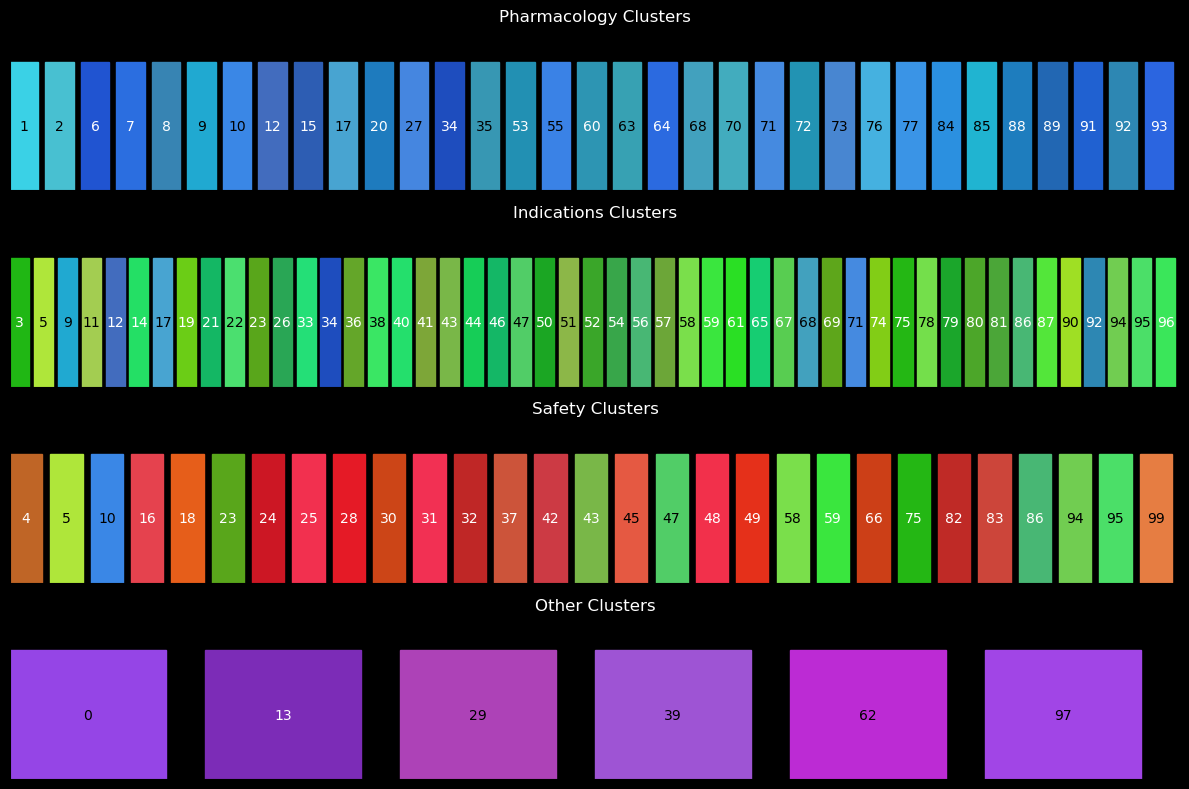

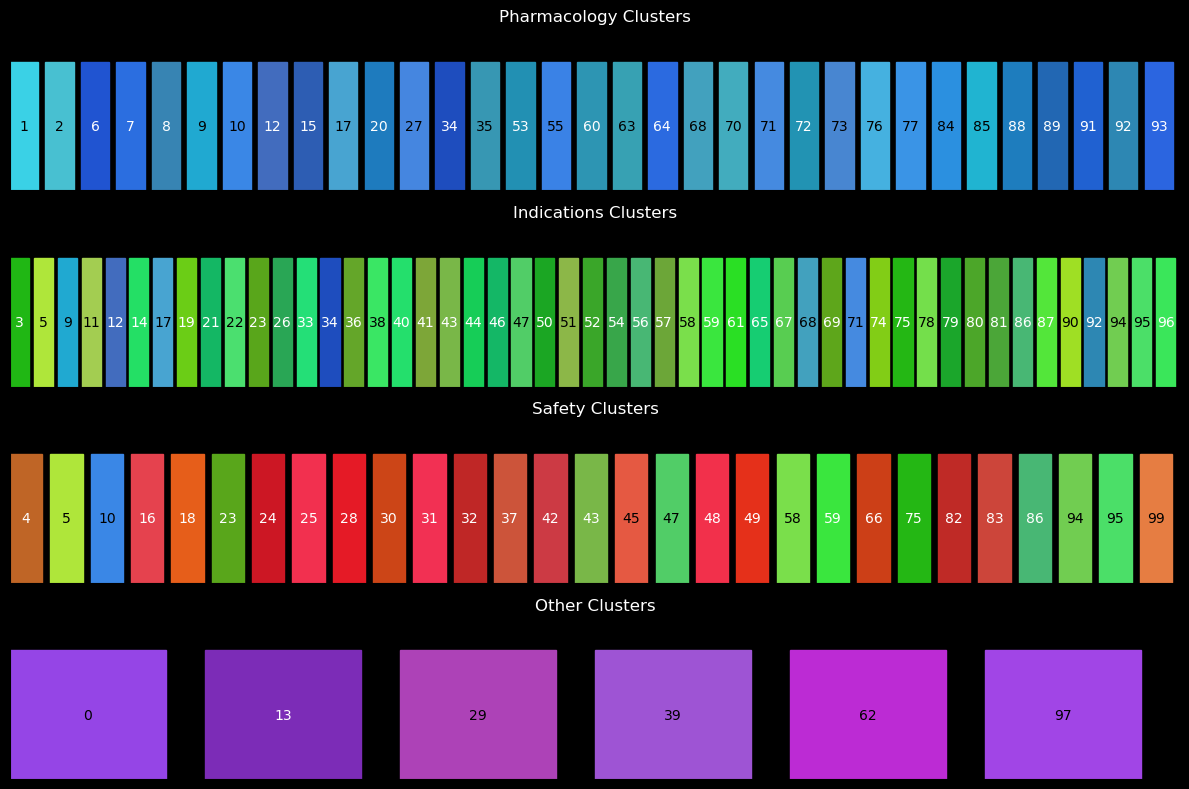

Average color distance: 0.5836
Minimum distance: 0.0008 between clusters 86 and 56
Maximum distance: 1.2399 between clusters 1 and 28

Most similar color pairs:
  Clusters 86 and 56: distance = 0.0008
  Clusters 88 and 20: distance = 0.0085
  Clusters 21 and 46: distance = 0.0088
  Clusters 32 and 82: distance = 0.0109
  Clusters 53 and 72: distance = 0.0110
Hex color dictionary: {"0": {"rgb": [0.5850000000000001, 0.2700000000000001, 0.9000000000000001], "hsv": [0.75, 0.7, 0.9000000000000001], "alpha": 1.0}, "1": {"rgb": [0.225625, 0.8212749999999999, 0.9025], "hsv": [0.52, 0.75, 0.9025], "alpha": 1.0}, "2": {"rgb": [0.2831404714206255, 0.7514916315291323, 0.8204457680820251], "hsv": [0.5213888754932395, 0.6548943483704847, 0.8204457680820251], "alpha": 1.0}, "3": {"rgb": [0.125318823118673, 0.7159650783015703, 0.0768527816016208], "hsv": [0.32069443774661976, 0.8926584774442731, 0.7159650783015703], "alpha": 1.0}, "4": {"rgb": [0.75, 0.3943369549492068, 0.14999999999999997], "hsv": [0

In [7]:
# Load configuration
config = load_config()

# Count leaf nodes
leaf_counts, branch_clusters = count_leaf_nodes(config['legend'])

# Print summary statistics
total_leafs = sum(leaf_counts.values())
print(f'Total leafs: {total_leafs}')
print(f'Counts per main branch: {leaf_counts}')
print(f'Clusters per main branch: {branch_clusters}')

# Assign colors with improved distribution
color_dict = improved_color_clusters(branch_clusters, config['cluster_label_tags'])

# Visualize color assignments
output_path_l_png = config['output_dir'] + '/cluster-qualifications_2025/colors/cluster_color_map_2025.png'
output_path_e_png = config['threejs_output_dir'] + 'cluster_color_map_2025.png'

visualize_cluster_colors(color_dict, branch_clusters, output_path_l_png)
visualize_cluster_colors(color_dict, branch_clusters, output_path_e_png)

# Analyze color distinctiveness
measure_color_distinctiveness(color_dict)

# Export hexadecimal colors to JSON
output_path_e_json = config['threejs_output_dir'] + 'cluster_color_map_2025.json'
output_path_l_json = config['output_dir'] + '/cluster-qualifications_2025/colors/cluster_color_map_2025.json'
export_hex_colors(color_dict, output_path_e_json)
export_hex_colors(color_dict, output_path_l_json)


In [8]:

with open(config['threejs_output_dir'] + 'cluster_label_tag_map_2025.json', 'w') as f:
    json.dump(config['cluster_label_tags'], f, indent=4)

with open(config['threejs_output_dir'] + 'cluster_label_map_2025.json', 'w') as f:
    json.dump(config['cluster_labels'], f, indent=4)

with open(config['threejs_output_dir'] + 'legend_2025.json', 'w') as f:
    json.dump(config['legend'], f, indent=4)
